RESEARCH QUESTION

Can we determine who receives the COVID-19 vaccine first after its development, and if so, who?

The purpose of this notebook is to import a dataset related to COVID-19 and use it for analyis to draw a conclusion that is relevant to the research question.

This notebook analyzes COVID-19 Case Demographics data.

Sources of data:

1. https://ourworldindata.org/mortality-risk-covid#case-fatality-rate-of-covid-19-by-age (Github dataset link is https://github.com/owid/covid-19-data/tree/master/public/data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import io
from numpy import array
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#@title Set maximum display rows for DataFrame
max_rows =  100#@param {type:"integer"}

pd.set_option('display.max_rows', max_rows)

In [3]:
#@title Reset maximum display rows for DataFrame
pd.reset_option('display.max_rows')

In [4]:
raw_covid_world_data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [5]:
raw_covid_world_data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40532,NaN,NaN,International,2020-08-26,696.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40533,NaN,NaN,International,2020-08-27,696.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40534,NaN,NaN,International,2020-08-28,696.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40535,NaN,NaN,International,2020-08-29,696.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The relevant parts of this dataset are the columns that are related to age and number of cases and deaths.

Hence we shall remove all the other columns.

In [6]:
raw_covid_world_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy'],
      dtype='object')

In [7]:
covid_world_data = raw_covid_world_data[["continent", "location", "date", "total_cases", "new_cases", "total_deaths", "new_deaths", "population", "population_density", "median_age", "aged_65_older", "aged_70_older", "life_expectancy"]]
covid_world_data

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,life_expectancy
0,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
1,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
2,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
3,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
4,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40532,NaN,International,2020-08-26,696.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40533,NaN,International,2020-08-27,696.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40534,NaN,International,2020-08-28,696.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40535,NaN,International,2020-08-29,696.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Refer https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data-codebook.md for codebook of complete dataset.

NOTE: The column ```median_age``` is the median age of the entire POPULATION and the columns ```aged_65_older``` and ```aged_70_older``` are respective shares of the entire POPULATION.

Since the age data is in relation to the whole population and not the cases, it could be inaccurate to use that in comparizon with the death data, which is based off on the cases. Thus we remove the columns related to the deaths.

In [8]:
covid_world_data.drop(["total_deaths", "new_deaths"], axis=1)

,continent,location,date,total_cases,new_cases,population,population_density,median_age,aged_65_older,aged_70_older,life_expectancy
0,Asia,Afghanistan,2019-12-31,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
1,Asia,Afghanistan,2020-01-01,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
2,Asia,Afghanistan,2020-01-02,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
3,Asia,Afghanistan,2020-01-03,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
4,Asia,Afghanistan,2020-01-04,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
...,...,...,...,...,...,...,...,...,...,...,...
40532,NaN,International,2020-08-26,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40533,NaN,International,2020-08-27,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40534,NaN,International,2020-08-28,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40535,NaN,International,2020-08-29,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Also, in the dataset, there are rows where the number of total cases is 0. These rows represent the dates for locations where the pandemic had not hit yet. They do not provide any information and hence can be dropped (removed).

In [9]:
covid_world_data = covid_world_data[covid_world_data.total_cases > 0]
covid_world_data.head(100)

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,life_expectancy
56,Asia,Afghanistan,2020-02-25,1.0,1.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
57,Asia,Afghanistan,2020-02-26,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
58,Asia,Afghanistan,2020-02-27,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
59,Asia,Afghanistan,2020-02-28,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
60,Asia,Afghanistan,2020-02-29,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Asia,Afghanistan,2020-06-09,20917.0,575.0,369.0,12.0,38928341.0,54.422,18.6,2.581,1.337,64.83
162,Asia,Afghanistan,2020-06-10,21459.0,542.0,384.0,15.0,38928341.0,54.422,18.6,2.581,1.337,64.83
163,Asia,Afghanistan,2020-06-11,22143.0,684.0,405.0,21.0,38928341.0,54.422,18.6,2.581,1.337,64.83
164,Asia,Afghanistan,2020-06-12,22890.0,747.0,426.0,21.0,38928341.0,54.422,18.6,2.581,1.337,64.83


The date column is not useful by itself. Thus, a column for number of days since pandemic started in a location is created for each row. This is obtained by finding the number of days between the date of a row and the date when the first case appeared in that location.

Creating a new column that represents the day of the year value, which is the number of days since the start of 2020 till that date of a row, including that date.

In [10]:
covid_world_data["date"] = pd.to_datetime(covid_world_data["date"], format='%Y-%m-%d')

covid_world_data["day_of_year"] = covid_world_data["date"].dt.dayofyear

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
#following function is used with the .apply function of pd.DataFrame to obtain days_elapsed column

location_first_case_day_dict = {}

def calculate_days_elapsed_since_first_case(row):
  if location_first_case_day_dict.get(row["location"]) == None:

    if row["date"].year == 2019:
      row["day_of_year"] = row["day_of_year"] - 365   #This line is to accomodate dates that are in 2019 instead of 2020

    location_first_case_day_dict[row["location"]] = row["day_of_year"]
    
  else:
    location_first_case_day_dict[row["location"]] = location_first_case_day_dict[row["location"]] if location_first_case_day_dict[row["location"]] < row["day_of_year"] else row["day_of_year"]
  
  return row["day_of_year"] - location_first_case_day_dict[row["location"]]

In [12]:
covid_world_data["days_elapsed_since_first_case"] = covid_world_data.apply(calculate_days_elapsed_since_first_case, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
covid_world_data.head(20)

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,life_expectancy,day_of_year,days_elapsed_since_first_case
56,Asia,Afghanistan,2020-02-25,1.0,1.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,56,0
57,Asia,Afghanistan,2020-02-26,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,57,1
58,Asia,Afghanistan,2020-02-27,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,58,2
59,Asia,Afghanistan,2020-02-28,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,59,3
60,Asia,Afghanistan,2020-02-29,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,60,4
61,Asia,Afghanistan,2020-03-01,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,61,5
62,Asia,Afghanistan,2020-03-02,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,62,6
68,Asia,Afghanistan,2020-03-08,4.0,3.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,68,12
71,Asia,Afghanistan,2020-03-11,7.0,3.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,71,15
75,Asia,Afghanistan,2020-03-15,10.0,3.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,75,19


In [14]:
covid_world_data["location"].drop_duplicates(keep="first").count()

211

Now we have the required columns for PCA, we must check that the data is clean and does not contain missing values or an NaN.

In [15]:
print(covid_world_data["total_cases"].isnull().values.any())
print(covid_world_data["population"].isnull().values.any())
print(covid_world_data["population_density"].isnull().values.any())
print(covid_world_data["days_elapsed_since_first_case"].isnull().values.any())

False
True
True
False


From above it is clear that the columns ``` population ``` and ``` population_density ``` have NaN values. Hence, these values must be tracked down and examined. This has been done by finding the ``` location ``` values that occur with an NaN value.

In [16]:
covid_world_data[covid_world_data.population.isnull() == True]["location"].drop_duplicates(keep="first")

40329    International
Name: location, dtype: object

In [17]:
covid_world_data[covid_world_data.population_density.isnull() == True]["location"].drop_duplicates(keep="first")

1001                            Anguilla
4746     Bonaire Sint Eustatius and Saba
12406                   Falkland Islands
15483                           Guernsey
19204                             Jersey
24827                         Montserrat
33719                        South Sudan
35344                              Syria
35526                             Taiwan
38866                            Vatican
39451                     Western Sahara
40329                      International
Name: location, dtype: object

Hence, removing the rows with missing ``` population_density ``` values.
Removing the rows with missing ``` population ``` values explicitly is not necessary as they are included with the above after examining the dataset.

In [18]:
covid_world_data = covid_world_data[covid_world_data.population_density.isnull() == False]
covid_world_data

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,life_expectancy,day_of_year,days_elapsed_since_first_case
56,Asia,Afghanistan,2020-02-25,1.0,1.0,0.0,0.0,3.892834e+07,54.422,18.6,2.581,1.337,64.83,56,0
57,Asia,Afghanistan,2020-02-26,1.0,0.0,0.0,0.0,3.892834e+07,54.422,18.6,2.581,1.337,64.83,57,1
58,Asia,Afghanistan,2020-02-27,1.0,0.0,0.0,0.0,3.892834e+07,54.422,18.6,2.581,1.337,64.83,58,2
59,Asia,Afghanistan,2020-02-28,1.0,0.0,0.0,0.0,3.892834e+07,54.422,18.6,2.581,1.337,64.83,59,3
60,Asia,Afghanistan,2020-02-29,1.0,0.0,0.0,0.0,3.892834e+07,54.422,18.6,2.581,1.337,64.83,60,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40288,NaN,World,2020-08-26,23924758.0,255024.0,819647.0,6500.0,7.794799e+09,58.045,30.9,8.696,5.355,72.58,239,239
40289,NaN,World,2020-08-27,24201451.0,276693.0,825944.0,6297.0,7.794799e+09,58.045,30.9,8.696,5.355,72.58,240,240
40290,NaN,World,2020-08-28,24484592.0,283141.0,832019.0,6075.0,7.794799e+09,58.045,30.9,8.696,5.355,72.58,241,241
40291,NaN,World,2020-08-29,24760720.0,276128.0,837476.0,5457.0,7.794799e+09,58.045,30.9,8.696,5.355,72.58,242,242


Another point to note is that there is a ``` location ``` label called "World" with rows at the end of the dataset. As the name suggests, these contain data for the entire World. The issues with having this present in the dataset is that the numbers for case data are very different in scale to the case data for the locations which can affect PCA. Also, the case data for the World is essentially an aggregate of the case data for the rest of the locations. Hence, this data does not fit here and must be removed.

In [19]:
covid_world_data = covid_world_data[covid_world_data.location != "World"]
covid_world_data.tail()

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,life_expectancy,day_of_year,days_elapsed_since_first_case
40044,Africa,Zimbabwe,2020-08-26,6196.0,126.0,166.0,11.0,14862927.0,42.729,19.6,2.822,1.882,61.49,239,158
40045,Africa,Zimbabwe,2020-08-27,6251.0,55.0,179.0,13.0,14862927.0,42.729,19.6,2.822,1.882,61.49,240,159
40046,Africa,Zimbabwe,2020-08-28,6292.0,41.0,189.0,10.0,14862927.0,42.729,19.6,2.822,1.882,61.49,241,160
40047,Africa,Zimbabwe,2020-08-29,6388.0,96.0,195.0,6.0,14862927.0,42.729,19.6,2.822,1.882,61.49,242,161
40048,Africa,Zimbabwe,2020-08-30,6406.0,18.0,196.0,1.0,14862927.0,42.729,19.6,2.822,1.882,61.49,243,162


Now we can use PCA on the columns for obtaining a metric that can be used for the case data. The columns used are ``` total_cases ```, ``` population ```, ``` population_density ``` and ``` days_elapsed_since_first_case ```.

Creating a new DataFrame that contains only the columns that we are going to use for PCA.

In [20]:
case_data = {"total_cases" : covid_world_data["total_cases"],
             "days_elapsed_since_first_case" : covid_world_data["days_elapsed_since_first_case"],
             "population": covid_world_data["population"],
             "population_density" : covid_world_data["population_density"]}

case_data = pd.DataFrame(case_data)

case_data

,total_cases,days_elapsed_since_first_case,population,population_density
56,1.0,0,38928341.0,54.422
57,1.0,1,38928341.0,54.422
58,1.0,2,38928341.0,54.422
59,1.0,3,38928341.0,54.422
60,1.0,4,38928341.0,54.422
...,...,...,...,...
40044,6196.0,158,14862927.0,42.729
40045,6251.0,159,14862927.0,42.729
40046,6292.0,160,14862927.0,42.729
40047,6388.0,161,14862927.0,42.729


Converting the DataFrame to a NumPy array.

In [21]:
case_data_array = case_data.to_numpy()
case_data_array

array([[1.0000000e+00, 0.0000000e+00, 3.8928341e+07, 5.4422000e+01],
       [1.0000000e+00, 1.0000000e+00, 3.8928341e+07, 5.4422000e+01],
       [1.0000000e+00, 2.0000000e+00, 3.8928341e+07, 5.4422000e+01],
       ...,
       [6.2920000e+03, 1.6000000e+02, 1.4862927e+07, 4.2729000e+01],
       [6.3880000e+03, 1.6100000e+02, 1.4862927e+07, 4.2729000e+01],
       [6.4060000e+03, 1.6200000e+02, 1.4862927e+07, 4.2729000e+01]])

Scaling the data down to have a mean of 0 and standard deviation 1. This is done to make sure that columns with greater variance do not get extra weightage when calculating principal components.

In [22]:
case_data_array_scaled = StandardScaler().fit_transform(case_data_array)
case_data_array_scaled

array([[-0.16894932, -1.714567  , -0.03598682, -0.18581491],
       [-0.16894932, -1.69561625, -0.03598682, -0.18581491],
       [-0.16894932, -1.67666551, -0.03598682, -0.18581491],
       ...,
       [-0.14455074,  1.31755207, -0.18164083, -0.19352941],
       [-0.14417842,  1.33650282, -0.18164083, -0.19352941],
       [-0.14410861,  1.35545356, -0.18164083, -0.19352941]])

Performing PCA

In [23]:
# create the PCA instance
pca = PCA(4)

# fit on data
pca.fit(case_data_array_scaled)

# access values and vectors
eigen_vectors = pca.components_
singular_values =pca.explained_variance_

# transform data
principal_components_case_data = pca.transform(case_data_array_scaled)

#printing
print("These are the principal components:")
print()
print(principal_components_case_data)
print()
print("These are the respective singular values:")
print()
print(singular_values)

These are the principal components:

[[-0.98369211 -0.66973881  1.10431702  0.60695122]
 [-0.97419854 -0.66416457  1.09112257  0.59896141]
 [-0.96470496 -0.65859032  1.07792812  0.59097159]
 ...
 [ 0.47167945  0.24055907 -1.1009793  -0.57860161]
 [ 0.4814212   0.24612759 -1.11416556 -0.58631405]
 [ 0.4909613   0.25170076 -1.12735847 -0.59425186]]

These are the respective singular values:

[1.35465411 1.01064404 0.91862242 0.71619463]


Selecting the first principal component with the largest singular value and pairing it with the main dataset DataFrame.

In [24]:
#Reindexing the DataFrame because of lost indices due to earlier remove drop row functions.
covid_world_data = covid_world_data.reset_index()

In [25]:
covid_world_data["case_metric"] = pd.DataFrame(principal_components_case_data[:, 0])

In [26]:
covid_world_data

,index,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,life_expectancy,day_of_year,days_elapsed_since_first_case,case_metric
0,56,Asia,Afghanistan,2020-02-25,1.0,1.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,56,0,-0.983692
1,57,Asia,Afghanistan,2020-02-26,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,57,1,-0.974199
2,58,Asia,Afghanistan,2020-02-27,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,58,2,-0.964705
3,59,Asia,Afghanistan,2020-02-28,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,59,3,-0.955211
4,60,Asia,Afghanistan,2020-02-29,1.0,0.0,0.0,0.0,38928341.0,54.422,18.6,2.581,1.337,64.83,60,4,-0.945718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34719,40044,Africa,Zimbabwe,2020-08-26,6196.0,126.0,166.0,11.0,14862927.0,42.729,19.6,2.822,1.882,61.49,239,158,0.452444
34720,40045,Africa,Zimbabwe,2020-08-27,6251.0,55.0,179.0,13.0,14862927.0,42.729,19.6,2.822,1.882,61.49,240,159,0.462080
34721,40046,Africa,Zimbabwe,2020-08-28,6292.0,41.0,189.0,10.0,14862927.0,42.729,19.6,2.822,1.882,61.49,241,160,0.471679
34722,40047,Africa,Zimbabwe,2020-08-29,6388.0,96.0,195.0,6.0,14862927.0,42.729,19.6,2.822,1.882,61.49,242,161,0.481421


Examining the columns ``` median_age ```, ``` aged_65_older ```, ``` aged_70_older ``` and ``` life_expectancy ``` for missing values.

In [27]:
print(covid_world_data["median_age"].isnull().values.any())
print(covid_world_data["aged_65_older"].isnull().values.any())
print(covid_world_data["aged_70_older"].isnull().values.any())
print(covid_world_data["life_expectancy"].isnull().values.any())

True
True
True
True


Since they all contain missing values, we can determine under which ``` location ``` labels these missing values occur.

In [28]:
covid_world_data[covid_world_data.median_age.isnull() == True]["location"].drop_duplicates(keep="first")

535                        Andorra
3528                       Bermuda
4543        British Virgin Islands
6129                Cayman Islands
9245                      Dominica
10797               Faeroe Islands
12638                    Gibraltar
12986                    Greenland
15784                  Isle of Man
17258                       Kosovo
18736                Liechtenstein
21161                       Monaco
23563     Northern Mariana Islands
26594        Saint Kitts and Nevis
27081                   San Marino
28476    Sint Maarten (Dutch part)
32236     Turks and Caicos Islands
Name: location, dtype: object

In [29]:
covid_world_data[covid_world_data.aged_65_older.isnull() == True]["location"].drop_duplicates(keep="first")

535                        Andorra
3528                       Bermuda
4543        British Virgin Islands
6129                Cayman Islands
9245                      Dominica
10797               Faeroe Islands
12638                    Gibraltar
12986                    Greenland
15784                  Isle of Man
17258                       Kosovo
18736                Liechtenstein
21161                       Monaco
23563     Northern Mariana Islands
26594        Saint Kitts and Nevis
27081                   San Marino
28476    Sint Maarten (Dutch part)
32236     Turks and Caicos Islands
Name: location, dtype: object

In [30]:
covid_world_data[covid_world_data.aged_70_older.isnull() == True]["location"].drop_duplicates(keep="first")

535                        Andorra
3528                       Bermuda
4543        British Virgin Islands
6129                Cayman Islands
9245                      Dominica
10797               Faeroe Islands
12638                    Gibraltar
12986                    Greenland
15784                  Isle of Man
17258                       Kosovo
18736                Liechtenstein
21161                       Monaco
23563     Northern Mariana Islands
26594        Saint Kitts and Nevis
27081                   San Marino
27761                       Serbia
28476    Sint Maarten (Dutch part)
32236     Turks and Caicos Islands
Name: location, dtype: object

In [31]:
covid_world_data[covid_world_data.life_expectancy.isnull() == True]["location"].drop_duplicates(keep="first")

17258    Kosovo
Name: location, dtype: object

These missing values cannot be filled in and hence the rows must be removed.

Instead of removing all the rows where any of the age data columns are missing, we create 4 new DataFrames with the ``` case_metric ``` column and one of the age data columns. Then the rows can be removed according to the missing values in each age data column.

In [32]:
case_metric_median_age = pd.DataFrame({"location": covid_world_data["location"], "case_metric": covid_world_data["case_metric"], "median_age": covid_world_data["median_age"]})
case_metric_median_age = case_metric_median_age[case_metric_median_age.median_age > 0]
case_metric_median_age

,location,case_metric,median_age
0,Afghanistan,-0.983692,18.6
1,Afghanistan,-0.974199,18.6
2,Afghanistan,-0.964705,18.6
3,Afghanistan,-0.955211,18.6
4,Afghanistan,-0.945718,18.6
...,...,...,...
34719,Zimbabwe,0.452444,19.6
34720,Zimbabwe,0.462080,19.6
34721,Zimbabwe,0.471679,19.6
34722,Zimbabwe,0.481421,19.6


In [33]:
case_metric_aged_65_older = pd.DataFrame({"location": covid_world_data["location"], "case_metric": covid_world_data["case_metric"], "aged_65_older": covid_world_data["aged_65_older"]})
case_metric_aged_65_older = case_metric_aged_65_older[case_metric_aged_65_older.aged_65_older > 0]
case_metric_aged_65_older

,location,case_metric,aged_65_older
0,Afghanistan,-0.983692,2.581
1,Afghanistan,-0.974199,2.581
2,Afghanistan,-0.964705,2.581
3,Afghanistan,-0.955211,2.581
4,Afghanistan,-0.945718,2.581
...,...,...,...
34719,Zimbabwe,0.452444,2.822
34720,Zimbabwe,0.462080,2.822
34721,Zimbabwe,0.471679,2.822
34722,Zimbabwe,0.481421,2.822


In [34]:
case_metric_aged_70_older = pd.DataFrame({"location": covid_world_data["location"], "case_metric": covid_world_data["case_metric"], "aged_70_older": covid_world_data["aged_70_older"]})
case_metric_aged_70_older = case_metric_aged_70_older[case_metric_aged_70_older.aged_70_older > 0]
case_metric_aged_70_older

,location,case_metric,aged_70_older
0,Afghanistan,-0.983692,1.337
1,Afghanistan,-0.974199,1.337
2,Afghanistan,-0.964705,1.337
3,Afghanistan,-0.955211,1.337
4,Afghanistan,-0.945718,1.337
...,...,...,...
34719,Zimbabwe,0.452444,1.882
34720,Zimbabwe,0.462080,1.882
34721,Zimbabwe,0.471679,1.882
34722,Zimbabwe,0.481421,1.882


In [35]:
case_metric_life_expectancy = pd.DataFrame({"location": covid_world_data["location"], "case_metric": covid_world_data["case_metric"], "life_expectancy": covid_world_data["life_expectancy"]})
case_metric_life_expectancy = case_metric_life_expectancy[case_metric_life_expectancy.life_expectancy > 0]
case_metric_life_expectancy

,location,case_metric,life_expectancy
0,Afghanistan,-0.983692,64.83
1,Afghanistan,-0.974199,64.83
2,Afghanistan,-0.964705,64.83
3,Afghanistan,-0.955211,64.83
4,Afghanistan,-0.945718,64.83
...,...,...,...
34719,Zimbabwe,0.452444,61.49
34720,Zimbabwe,0.462080,61.49
34721,Zimbabwe,0.471679,61.49
34722,Zimbabwe,0.481421,61.49


Now we have four DataFrames with a ``` case_metric ``` versus an age data column by ``` location ```. 

As observed, for a particular ``` location ```, the ``` case_metric ``` value starts at a rough lower bound and steadily progresses upwards towards a rough higher bound at the last values for the ``` location ```. All the age data column values for a ``` location ``` are the same. Since the bounds and ranges for different ``` locations ```s are different, we can aggregate these in the form of a mean. This mean can then be paired with the corresponding age data value. Thus, we get datapoints with unique values instead of multiple datapoints in a line when plotted on a scatter plot. Also, if we have multiple ``` case_metric ``` values for the same age data value, we cannot use the Pearson’s Product Moment Correlation Coefficient for determining correlation as one criterion of using it is that the data must appear random on random. This means that the data must not be controlled and having multiple datapoints with the same value for one of the axes suggests a controlled variable and this makes the result inaccurate. 

In [36]:
count = 0 #keeps track of how many rows (or case_metric values) have been used for the operation for each median_age (or location)
case_metric_median_age_dict = {}  #the dictionary

for index, row in case_metric_median_age.iterrows():

  if case_metric_median_age_dict.get(row["median_age"]) == None:  #if a case_metric value for that median_age (or location) does not exist
    
    count = 1

    case_metric_median_age_dict[row["median_age"]] = row["case_metric"] #add that case_metric value in the dictionary
    
  else:

    case_metric_median_age_dict[row["median_age"]] *= count #undo the mean operation to get sum of all the previous case_metric values added

    count += 1  #update the count

    case_metric_median_age_dict[row["median_age"]] += row["case_metric"]  #add the new case_metric value

  case_metric_median_age_dict[row["median_age"]] /= count #calculate the mean and store it
  

case_metric_median_age_dict

{15.1: -0.26051811559441224,
 16.4: -0.24869535598708623,
 16.7: -0.28227203877799484,
 16.8: -0.2517077105277984,
 17.0: 0.022584072778658607,
 17.5: -0.34625617096841166,
 17.6: -0.21638864015226442,
 17.7: -0.20501985292929248,
 18.0: -0.34560893831266537,
 18.1: 0.11342821356610074,
 18.3: -0.2978779965404746,
 18.6: -0.006689726565624895,
 18.7: -0.26666521168652957,
 18.8: -0.21881336893385545,
 19.0: -0.27507622604535065,
 19.1: -0.3687121879224335,
 19.2: -0.30699447939816044,
 19.3: -0.33673037653862364,
 19.4: -0.2893513932463294,
 19.6: -0.2534605076846824,
 19.7: -0.1492374613370323,
 19.8: 0.09048771937817694,
 20.0: -0.013685230095308495,
 20.3: -0.3077843212659383,
 20.4: -0.40261213955564373,
 21.1: -0.1606809437890802,
 21.5: -0.3100011613241106,
 22.0: -0.30363443739109597,
 22.2: -0.5980460407309709,
 22.4: -0.30632310362835125,
 22.6: -0.31346795682085116,
 22.9: -0.2092522392832637,
 23.1: -0.28400716816014093,
 23.2: -0.17778904371988521,
 23.3: -0.493914759728450

In [37]:
count = 0 #keeps track of how many rows (or case_metric values) have been used for the operation for each aged_65_older (or location)
case_metric_aged_65_older_dict = {}  #the dictionary

for index, row in case_metric_aged_65_older.iterrows():

  if case_metric_aged_65_older_dict.get(row["aged_65_older"]) == None:  #if a case_metric value for that aged_65_older (or location) does not exist
    
    count = 1

    case_metric_aged_65_older_dict[row["aged_65_older"]] = row["case_metric"] #add that case_metric value in the dictionary
    
  else:

    case_metric_aged_65_older_dict[row["aged_65_older"]] *= count #undo the mean operation to get sum of all the previous case_metric values added

    count += 1  #update the count

    case_metric_aged_65_older_dict[row["aged_65_older"]] += row["case_metric"]  #add the new case_metric value

  case_metric_aged_65_older_dict[row["aged_65_older"]] /= count #calculate the mean and store it
  

case_metric_aged_65_older_dict

{1.1440000000000001: 0.031943417641257486,
 1.307: -0.07998239156448086,
 2.168: -0.19934599638352732,
 2.339: -0.3254086239810942,
 2.345: -0.12127808066860245,
 2.355: -0.10758350978130166,
 2.372: -0.2173483032329333,
 2.405: -0.23756611860402355,
 2.4090000000000003: -0.21638864015226442,
 2.48: -0.26625497254234853,
 2.4859999999999998: -0.28227203877799484,
 2.519: -0.29572239278577117,
 2.5380000000000003: -0.3687121879224335,
 2.553: -0.26051811559441224,
 2.562: -0.36661318743838067,
 2.5810000000000004: -0.006689726565624895,
 2.6860000000000004: -0.11198749996222013,
 2.7310000000000003: -0.2667807845543372,
 2.7510000000000003: 0.5400397853961187,
 2.822: -0.2911948837366921,
 2.839: -0.2186796589253001,
 2.846: -0.30632310362835125,
 2.886: -0.4368145472497895,
 2.9219999999999997: -0.3376449129311352,
 2.929: -0.24172252429445848,
 2.9330000000000003: -0.18731939972938125,
 2.963: -0.5506858906141168,
 2.9739999999999998: -0.2823972082142956,
 2.9789999999999996: -0.34197

In [38]:
count = 0 #keeps track of how many rows (or case_metric values) have been used for the operation for each aged_70_older (or location)
case_metric_aged_70_older_dict = {}  #the dictionary

for index, row in case_metric_aged_70_older.iterrows():

  if case_metric_aged_70_older_dict.get(row["aged_70_older"]) == None:  #if a case_metric value for that aged_70_older (or location) does not exist
    
    count = 1

    case_metric_aged_70_older_dict[row["aged_70_older"]] = row["case_metric"] #add that case_metric value in the dictionary
    
  else:

    case_metric_aged_70_older_dict[row["aged_70_older"]] *= count #undo the mean operation to get sum of all the previous case_metric values added

    count += 1  #update the count

    case_metric_aged_70_older_dict[row["aged_70_older"]] += row["case_metric"]  #add the new case_metric value

  case_metric_aged_70_older_dict[row["aged_70_older"]] /= count #calculate the mean and store it
  

case_metric_aged_70_older_dict

{0.526: 0.031943417641257486,
 0.617: -0.07998239156448086,
 1.114: -0.12127808066860245,
 1.285: -0.3687121879224335,
 1.308: -0.19934599638352732,
 1.337: -0.006689726565624895,
 1.358: -0.21638864015226442,
 1.3619999999999999: -0.23756611860402355,
 1.3780000000000001: -0.26051811559441224,
 1.3869999999999998: -0.2173483032329333,
 1.4169999999999998: -0.3254086239810942,
 1.446: -0.28227203877799484,
 1.4469999999999998: 0.5400397853961187,
 1.486: -0.29572239278577117,
 1.496: -0.2667807845543372,
 1.504: -0.36661318743838067,
 1.525: -0.2186796589253001,
 1.528: -0.11198749996222013,
 1.53: -0.10758350978130166,
 1.5419999999999998: -0.26625497254234853,
 1.565: -0.36351308975605184,
 1.5819999999999999: -0.18731939972938125,
 1.5830000000000002: -0.3376449129311352,
 1.642: -0.2823972082142956,
 1.686: -0.24172252429445848,
 1.726: -0.40261213955564373,
 1.733: -0.25239511130075415,
 1.745: 0.022584072778658607,
 1.7519999999999998: -0.30632310362835125,
 1.756: -0.30699447939

In [39]:
count = 0 #keeps track of how many rows (or case_metric values) have been used for the operation for each life_expectancy (or location)
case_metric_life_expectancy_dict = {}  #the dictionary

for index, row in case_metric_life_expectancy.iterrows():

  if case_metric_life_expectancy_dict.get(row["life_expectancy"]) == None:  #if a case_metric value for that life_expectancy (or location) does not exist
    
    count = 1

    case_metric_life_expectancy_dict[row["life_expectancy"]] = row["case_metric"] #add that case_metric value in the dictionary
    
  else:

    case_metric_life_expectancy_dict[row["life_expectancy"]] *= count #undo the mean operation to get sum of all the previous case_metric values added

    count += 1  #update the count

    case_metric_life_expectancy_dict[row["life_expectancy"]] += row["case_metric"]  #add the new case_metric value

  case_metric_life_expectancy_dict[row["life_expectancy"]] /= count #calculate the mean and store it
  

case_metric_life_expectancy_dict

{53.28: -0.2978779965404746,
 54.24: -0.28227203877799484,
 54.33: -0.5980460407309709,
 54.69: 0.5400397853961187,
 54.7: -0.3687121879224335,
 57.4: -0.2667807845543372,
 57.78: -0.18731939972938125,
 58.32: -0.36351308975605184,
 58.74: -0.30632310362835125,
 59.29: -0.13961350535047012,
 59.31: -0.29572239278577117,
 60.19: -0.3100011613241106,
 60.68: 0.022584072778658607,
 60.85: -0.24697657990491548,
 61.04: -0.2186796589253001,
 61.15: -0.23756611860402355,
 61.49: -0.2911948837366921,
 61.58: -0.2870825447574961,
 61.6: -0.25239511130075415,
 61.77: -0.2842393431983907,
 62.05: -0.3254086239810942,
 62.42: -0.26051811559441224,
 63.37: -0.19934599638352732,
 63.71: -0.30363443739109597,
 63.89: -0.26625497254234853,
 64.0: -0.3017152624587486,
 64.07: -0.1606809437890802,
 64.1: -0.30699447939816044,
 64.13: 0.371171499568479,
 64.26: -0.34197309624017636,
 64.32: -0.5506858906141168,
 64.5: -0.31346795682085116,
 64.57: -0.297757340789948,
 64.83: -0.006689726565624895,
 64.9

Now this data can be plot as a scatter plot.

In [46]:
sns.set()
sns.set(context="notebook", style="darkgrid", palette="deep", font_scale=1)

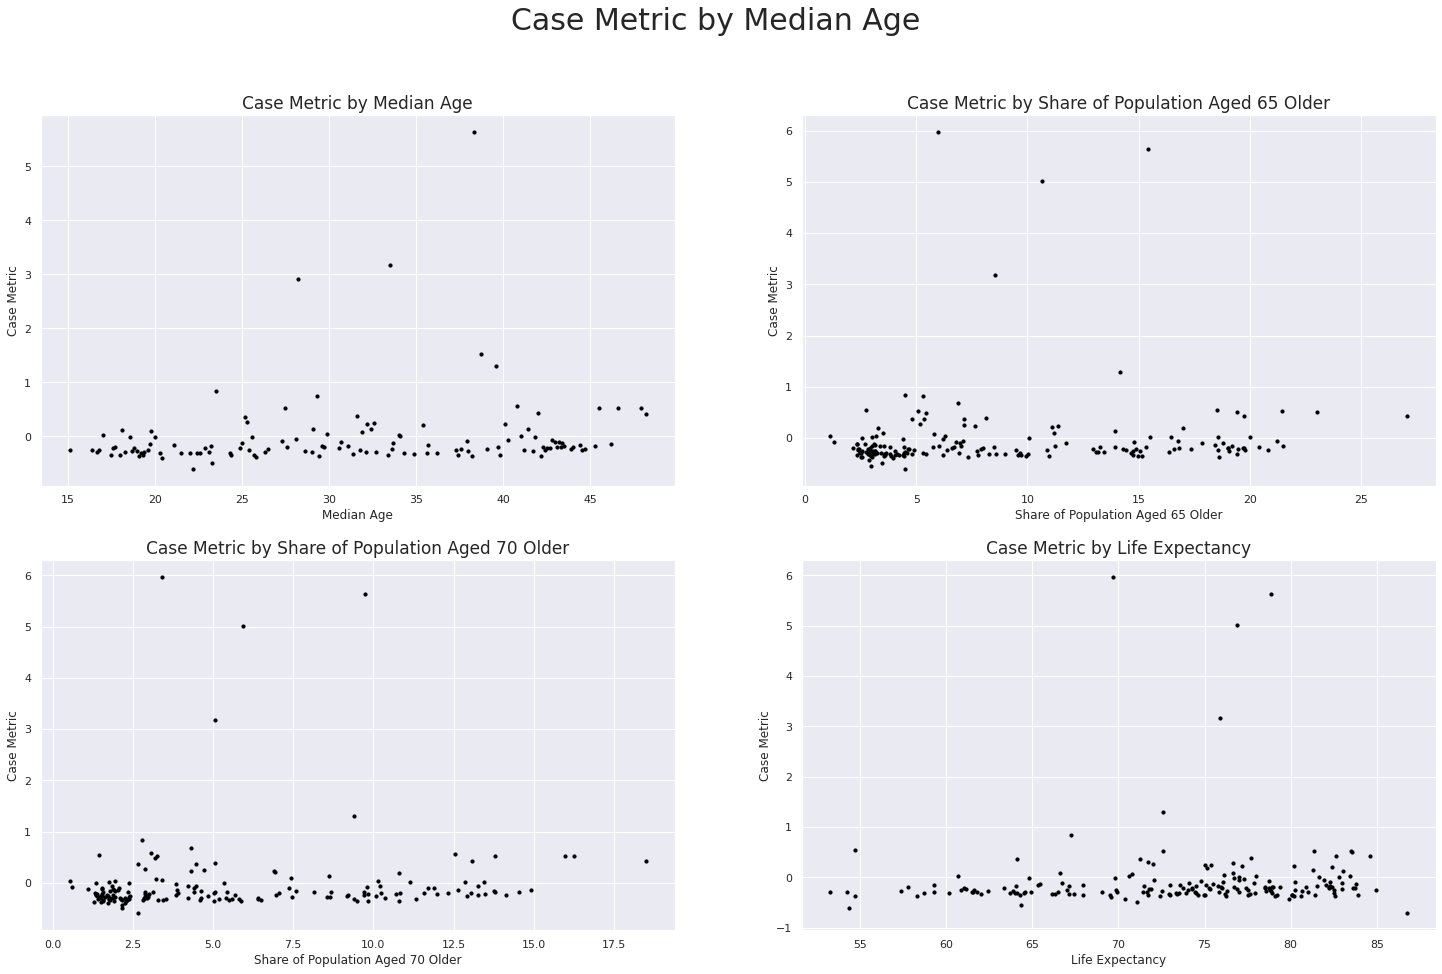

In [113]:
figure = plt.figure(figsize=(25, 15))

case_metric_median_age_subplot = figure.add_subplot(221)
case_metric_aged_65_older_subplot = figure.add_subplot(222)
case_metric_aged_70_older_subplot = figure.add_subplot(223)
case_metric_life_expectancy_subplot = figure.add_subplot(224)


for key in case_metric_median_age_dict:
  case_metric_median_age_subplot.scatter(x=key, y=case_metric_median_age_dict[key], s=10, c="black")

for key in case_metric_aged_65_older_dict:
  case_metric_aged_65_older_subplot.scatter(x=key, y=case_metric_aged_65_older_dict[key], s=10, c="black")

for key in case_metric_aged_70_older_dict:
  case_metric_aged_70_older_subplot.scatter(x=key, y=case_metric_aged_70_older_dict[key], s=10, c="black")

for key in case_metric_life_expectancy_dict:
  case_metric_life_expectancy_subplot.scatter(x=key, y=case_metric_life_expectancy_dict[key], s=10, c="black")

plt.suptitle("Case Metric by Median Age", fontsize=30)
case_metric_median_age_subplot.set_title("Case Metric by Median Age", fontsize=17)
case_metric_aged_65_older_subplot.set_title("Case Metric by Share of Population Aged 65 Older", fontsize=17)
case_metric_aged_70_older_subplot.set_title("Case Metric by Share of Population Aged 70 Older", fontsize=17)
case_metric_life_expectancy_subplot.set_title("Case Metric by Life Expectancy", fontsize=17)

case_metric_median_age_subplot.set_xlabel("Median Age")
case_metric_aged_65_older_subplot.set_xlabel("Share of Population Aged 65 Older")
case_metric_aged_70_older_subplot.set_xlabel("Share of Population Aged 70 Older")
case_metric_life_expectancy_subplot.set_xlabel("Life Expectancy")
case_metric_median_age_subplot.set_ylabel("Case Metric")
case_metric_aged_65_older_subplot.set_ylabel("Case Metric")
case_metric_aged_70_older_subplot.set_ylabel("Case Metric")
case_metric_life_expectancy_subplot.set_ylabel("Case Metric")

plt.show()

Looking at the Case Metric by Median Age graph, it is seen that the vertical spread at the lower end and higher end of median age is lesser than the vertical spread at the middle. At the middle, where median age is around 25 to 40, the case metric has a much higher variance. This includes what seem to be outliers to the general cluster of points around a case metric of 0. These outliers have a case metric above 2. Clearly, they had a massive surge of cases compared to the others with case metrics near 0. If these points are isolated and examined, they are found to represent the countries India, Brazil and USA with median ages of 28.2, 33.5 and 38.3 respectively. These countries are known to have experienced a very high surge in cases. This suggests that locations with a median age around 25 to 40 have a higher chance to experience a surge in cases. Another trio of interesting points are the ones with median age above 45 and case metric above 0 on the graph. They represent Germany, Italy and Japan which is interesting as they were known to have a surge in cases too in the first few months of the pandemic. The shape of the graph is roughly linear at the ends with it curving upwards in the middle. 

Looking at the Case Metric by Share of Population Aged 65 Above graph, the outliers with a much a higher case metric can be seen with values between 5 to 15. A cluster of points can also be seen with share values of around 4. This, however, is a result of more locations having share values in that range rather than a suggestion of an interesting aspect. The vertical spread looks similar throughout the values with a slightly larger vertical spread near the lower end of share values. However, we cannot compare the vertical spreads at different share values because there is a lack of points at the upper end of share values. 

Looking at the Case Metric by Share of Population Aged 70 Above graph, it is quite similar to the Case Metric by Share of Population Aged 65 Above graph. The values would be shifted slightly to the left considering there is a lesser share of population aged 70 above than there is a share of population aged 65 above. 

Looking at the Case Metric by Life Expectancy graph, there is are more points with a higher life expectancy. The difference in vertical spread is hard to comment on considering the lesser points with a lower life expectancy 

Thus, the following inferences can be made:


*   There is more variation in the spread of cases in locations where the median age ranges from 25 to 40. 

*   In the range of 25 to 40 for median age, there is a higher chance that the spread of cases becomes uncontrollably high and case numbers increase rapidly. 

*   The spread of cases in locations with very low or very high median age such as below 20 and above 50 is very low in comparison. 




This contributes to the argument that the population aged younger, above 20 and below 45 should be prioritized for vaccination over other age groups.